<a href="https://colab.research.google.com/github/Wyndegarde/UFC-Scraper/blob/main/UFC_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes: 

* Averages for each fighter are kept static despite date, so won't show different averages for each fight. I.e. if a fighter were to become more boxing centric we wouldnt pick this up as only their most recent averages are recorded. 

* So next step is to fix this, scrape all fight data for each fight, and use this to calculate their average for only fights which have occured. 

* Might be idea then to only keep fights in which both fighters have had two fights in ufc. either that or find a way to set the average for a fighter who is just entering the UFC. 

* documentation for datetime: https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior


* Tutorial here: https://www.dataquest.io/blog/python-datetime-tutorial/ 

In [ ]:
#!pip3 install requests
#!pip3 install beautifulsoup4
import requests
import pprint as pp
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil.relativedelta import relativedelta

from datetime import datetime, date
import math
import statistics

## Links to all events and functions

In [ ]:
def parse_webpage(link):
  get = requests.get(link)
  soup = BeautifulSoup(get.content, 'lxml')
  return(soup)

In [ ]:
def strip_ufc_text(text):
  text = text.strip().replace('\n','').replace("    ",'')
  return(text)

In [ ]:
all_links = [] # List to store all URLs 
ufc_URL = 'http://ufcstats.com/statistics/events/completed' # Link to UFC stats page with all events 
sequence = list(range(1,11)) # Updating this to only do first 10 pages, as this is 6 years worth of fights, anything beyond that probably won't give much info. 
                             # Can just change second value in range argument if you want more. Or alternatively go to the webpage which has all cards on one page. Less flexibility this way tho. 

                             # There are 22 pages, think there may be a better way to do this, but for now will do. 
                             # Idea: read in the page, find the section with page numbers, save 1 and then the final page text, save each as variable and use those for range. 
                             # More work than necessary tho, but idea for future. 

for i in sequence: 
  url = requests.get(ufc_URL, params={'page':i}) # Gets the page, 1 through 22.
  soup = BeautifulSoup(url.content, 'lxml') # Parses the webpage 

  for link in soup.find_all('a',class_="b-link b-link_style_black", href = True): # For each link in each page, go through them
    event = link['href'] # assigns each link to 'event'
    all_links.append(event) # appends this link to main list. 

    # print(f'added {link.text}') # Used to show which events have been added to the list. 

    
  print(f'Page {i} complete') # Just used as indicator to show page has been processed. 

In [ ]:
# from requests.exceptions import HTTPError # This block here will raise errors if something wrong occurs. see: https://realpython.com/python-requests/

# # 200's = success, 300's = redirects, 400's = client errors and 500's = server errors. 

# for url in all_links:
#     try:
#         response = requests.get(url)

#         # If the response was successful, no Exception will be raised
#         response.raise_for_status()
#     except HTTPError as http_err:
#         print(f'HTTP error occurred: {http_err}')  # Python 3.6
#     except Exception as err:
#         print(f'Other error occurred: {err}')  # Python 3.6
#     else:
#         # print('Success!')
#         continue             
# #         # No errors when going through all the event links. But the code takes a good while to run through all links. 5 minute, 46 second runtime. 549 links. 

## Scraping fight info from all events


In [ ]:
# Notes: Gathered the names through scraping, then added red/blue prefixes. 
#        Find out if there is a better way to do this. 

event_stats = pd.DataFrame(columns = ['date','location',
               'red_fighter', 'blue_fighter', 'winner',
               'red_knockdowns','blue_knockdowns',
               'red_sig_strike', 'blue_sig_strike',
               'red_sig_strike_percent', 'blue_sig_strike_percent',
               'red_total_strikes', 'blue_total_strikes',
               'red_takedowns', 'blue_takedowns',
               'red_takedown_percent', 'blue_takedown_percent',
               'red_submission_attempts', 'blue_submission_attempts',
               'red_reversals', 'blue_reversals',
               'red_control_time', 'blue_control_time'])

fighter_profile_df = pd.DataFrame(columns =
                                  ['red_Record','red_Height','red_Weight','red_Reach','red_STANCE','red_DOB','red_SLpM','red_Str_Acc','red_SApM','red_Str_Def','red_TD_Avg','red_TD_Acc','red_TD_Def','red_Sub_Avg',
                                   'blue_Record','blue_Height','blue_Weight','blue_Reach','blue_STANCE','blue_DOB','blue_SLpM','blue_Str_Acc','blue_SApM','blue_Str_Def','blue_TD_Avg','blue_TD_Acc','blue_TD_Def','blue_Sub_Avg'])

In [ ]:
for event in all_links:           # Goes through each event that was saved. 
  ufc_card = parse_webpage(event) # Parses each event. 


  event_info = ufc_card.find(class_ = 'b-list__box-list').text.replace('\n','').split('      ') # Gets the Date and Location. 
  date = event_info[3]
  location = event_info[-1]

  for fights in ufc_card.find_all(class_ ='b-flag b-flag_style_green'): # Goes the statistics page of each fight for each event. 
    red_vs_blue = parse_webpage(fights['href']) # Parses each webpage. 
    fighter_links = []
    for link in red_vs_blue.find_all('a',class_ = 'b-link b-link_style_black',limit = 2): # Gets the links to each fighter's profile page and stores them in a list. 
        fighter_links.append(link.get('href'))


    all_info = []
    for link in fighter_links: # We get the links for both fighters in each fight and go through both. 
      profile = parse_webpage(link)
      record = profile.find(class_ = 'b-content__title-record') # First find their record. 
      all_info.append(strip_ufc_text(record.text).split(':'))   # Strip it down and add it to the list

      career_info = profile.find_all(class_="b-list__box-list-item b-list__box-list-item_type_block") # Next we go through all of the summary stats for each fighter. 
      for each in career_info:
        output = strip_ufc_text(each.text).split(':') # Strip the text containing the info and then split it by colons, to have a list where each entry is a 2 element list containing the name of the stat and the stat itself. 
        all_info.append(output) # Add the info for each fighter to the list. This adds all red fighter stats, then loops through again to add blue fighter stats to end of that. 


    # Once both fighter statistics from a single fight have been extracted and stored in a list, we need to process that list and add it to the dataframe as one row. 
    all_info.remove(all_info[10]) # This is an empty entry due to website formatting. 
    all_info.remove(all_info[-5]) # This is an empty entry due to website formatting. 
    #print(all_info)
    information = [i[1] for i in all_info] # This here creates a list containing only the actual statistics (effectively discarding the names)
    information_series = pd.Series(information,index = fighter_profile_df.columns) # converts this list to a series so it can be added to the dataframe. 
    fighter_profile_df = fighter_profile_df.append(information_series, ignore_index=True) # Finally add the fighter stats to the dataframe. 

    ######## NOTE ON THIS BLOCK: IT DOESNT ACCOUNT FOR DRAWS, SMALL SAMPLE SIZE, BUT IM SURE CURRENTLY IT TREATS A DRAW AS A BLUE WIN WHICH IS NOT GOOD. ###############################
    
    # This statement here finds the part of the webpage which states the winner of the fight. Win and loss has a different class, 
    # so if the class of the first box (i.e. red fighter) is not "style_green" then they lost and the entry for winner becomes 0 (i.e. blue fighter won)
    # Takes advantage of the fact that if .find doesnt find something, then it returns a NoneType Object
    if red_vs_blue.find(class_ = 'b-fight-details__person').find(class_ = 'b-fight-details__person-status b-fight-details__person-status_style_green') == None: 
      win = 0
    else: 
      win = 1 # This sets it so if the red corner wins we get 1 and if the blue corner wins we get 0. 

    table = []
    for link in red_vs_blue.find_all(class_ = 'b-fight-details__table-text', limit = 20): # Goes through the table containing the key information from each fight and stores the stats in a list. 
        entry = strip_ufc_text(link.get_text())
        table.append(entry)

    # This code here adds the date, location and winner information to the list and then adds that row to the master dataframe. 
    table.insert(0,date)
    table.insert(1,location)
    table.insert(4,win)
    stats = pd.Series(table, index = column_names)
    event_stats = event_stats.append(stats,ignore_index=True)

In [ ]:
UFC_DataFrame = pd.concat([event_stats,fighter_profile_df],axis = 1)

In [ ]:
UFC_DataFrame.head()

In [ ]:
UFC_DataFrame.to_csv('ufc.csv',index = False)

# Working with the scraped Data

In [ ]:
UFC_DataFrame = pd.read_csv('drive/MyDrive/ufc.csv') # Added in after scraping so I don't need to scrape every time. 

In [ ]:
def get_fighter(df,fighter): 
  df1 = df[df['red_fighter'] == fighter ] 
  df2 = df[df['blue_fighter'] == fighter ]
  df3 = pd.concat([df1,df2],axis = 0)
  return(df3)


# Taken from Lewis' code

#Function for changing height column to inches and then to cm 
def height_to_cm(height):
    height =height.split("' ")
    feet = float(height[0])
    inch = float(height[1].replace("\"",""))
    feet_inch = (12*feet) + inch
    return(feet_inch*2.54)


#Convert both reach columns into cm
def reach_cm(reach):
    if reach == '--': # bit of a messy change, but currently I replace all of these strings with NaN, then work out the newly mean of the column excluding these values and finally replace the NaN with the mean. 
        return(np.nan)
    else: 
        reach = float(reach.replace('"',''))
        return(reach*2.54) # might add math.floor to round these down and get integer values for height in cm instead of including decimals. 


In [ ]:
UFC = UFC_DataFrame.copy()

UFC['date'] = UFC['date'].apply(lambda x: datetime.strptime(x,'%B %d, %Y')) 

for column in UFC.columns: 
  if 'DOB' in column:
    UFC[column] = UFC[column].apply(lambda x: datetime.strptime(x,'%b %d, %Y')) 

UFC = UFC.replace('---','0')
UFC['blue_STANCE'] = UFC['blue_STANCE'].replace(np.nan,'Orthodox') # Choosing the replace with Orthodox because it is the most common stance. 
UFC['red_STANCE'] = UFC['blue_STANCE'].replace(np.nan,'Orthodox') # see above
#UFC = UFC.sort_values(by = 'date', ascending = False) # This is not totally necessary, but handy for if anything gets jumbled up later on when appending. 

UFC_subset = UFC.copy()
UFC_subset = UFC_subset[['date', 'location', 'red_fighter', 'blue_fighter', 'winner','red_sig_strike',
                                 'blue_sig_strike', 'red_sig_strike_percent', 'blue_sig_strike_percent',
                                 'red_total_strikes', 'blue_total_strikes', 'red_takedowns',
                                 'blue_takedowns', 'red_takedown_percent', 'blue_takedown_percent',
                                 'red_submission_attempts', 'blue_submission_attempts', 'red_Record',
                                 'red_Height', 'red_Weight', 'red_Reach', 'red_STANCE', 'red_DOB', 'blue_Record', 'blue_Height',
                                 'blue_Weight', 'blue_Reach', 'blue_STANCE', 'blue_DOB']]


# This block here pulls all the percentage columns, then removes the % from each and converts them to decimal. 
percent_names = []
of_columns = []
height_columns = []
reach_columns = []

for name in UFC_subset.columns: 

  if 'percent' in name:
    percent_names.append(name)

  elif UFC_subset[name].dtype == object and sum(UFC_subset[name].apply(lambda x: 'of' in str(x))) > 0 and name != 'red_fighter' and name != 'blue_fighter' : # This is definitely not the best way to do this, find better way.
    of_columns.append(name) # This block gets all the columns with ' x of y' in them and stores them in a list for processing.

  elif 'Height' in name: # This block converts the height and reach columns from inches to cm. 
    height_columns.append(name)
    UFC_subset[name] = UFC_subset[name].apply(lambda x:height_to_cm(x))

  elif 'Reach' in name: 
    reach_columns.append(name)
    UFC_subset[name] = UFC_subset[name].apply(lambda x:reach_cm(x))


for column in percent_names: 
  UFC_subset[column] = UFC_subset[column].str.strip('%').astype('int')/100


for column in of_columns: # This block converts all the columns from strings containing "x of y" to two columns corresponding to attempted and landed. 
  column_as_list = UFC_subset[column].tolist()
  splitting_column = []

  for each in column_as_list: 
    splitting_column.append(each.split(' of '))
  
  attempted = [float(i[1]) for i in splitting_column] 
  landed = [float(i[0]) for i in splitting_column] 

  attempted_suffix = column + '_attempted'
  landed_suffix = column + '_landed'
  percent_suffix = column + '_percent'

  UFC_subset[attempted_suffix] = attempted 
  UFC_subset[landed_suffix] = landed
  UFC_subset[percent_suffix] =  UFC_subset[landed_suffix] / UFC_subset[attempted_suffix] 
  UFC_subset[percent_suffix] = UFC_subset[percent_suffix].fillna(0)

  UFC_subset = UFC_subset.drop(columns = column)

# IMPROVEMENT: change this to calculate the mean reach for each weight class, that way we will get a mean reach that is proportional and more accurate (can't have a 5" fighter with the reach of someone 6")
red_mean_reach = statistics.mean(UFC_subset['red_Reach'][~np.isnan(UFC_subset['red_Reach'])])
blue_mean_reach = statistics.mean(UFC_subset['blue_Reach'][~np.isnan(UFC_subset['blue_Reach'])])

UFC_subset['red_Reach'] = UFC_subset['red_Reach'].fillna(red_mean_reach)
UFC_subset['blue_Reach'] = UFC_subset['blue_Reach'].fillna(blue_mean_reach)
# This is is a little convoluted compared to just hard coding the actual column names in, but wanted to avoid using the names to avoid typos. although different errors could occur here technically. 

UFC_subset['Height_diff'] = UFC_subset[height_columns[0]] - UFC_subset[height_columns[1]] # Red height minus Blue height. So positve value suggests red taller, negative implies red shorter.
UFC_subset['Reach_diff'] = UFC_subset[reach_columns[0]] - UFC_subset[reach_columns[1]]  # Same as for height. 

UFC_subset['red_age'] = UFC_subset['date'].sub(UFC_subset['red_DOB']).dt.days.div(365.25).round(0).astype(int)
UFC_subset['blue_age'] = UFC_subset['date'].sub(UFC_subset['blue_DOB']).dt.days.div(365.25).round(0).astype(int)

(array([ 38., 125., 387., 332., 529., 702., 397., 252.,  92.,  30.]),
 array([152.4  , 158.496, 164.592, 170.688, 176.784, 182.88 , 188.976,
        195.072, 201.168, 207.264, 213.36 ]),
 <a list of 10 Patch objects>)

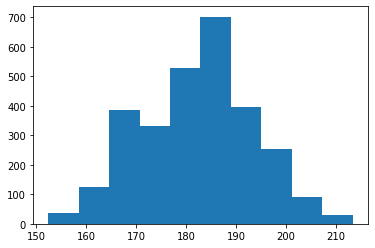

In [ ]:
plt.hist(UFC_subset['red_Reach'])

In [ ]:
plt.hist(UFC_subset['blue_Reach'])

In [ ]:
UFC_subset.isna().sum()

date                            0
location                        0
red_fighter                     0
blue_fighter                    0
winner                          0
red_sig_strike_percent          0
blue_sig_strike_percent         0
red_takedown_percent            0
blue_takedown_percent           0
red_submission_attempts         0
blue_submission_attempts        0
red_Record                      0
red_Height                      0
red_Weight                      0
red_Reach                       0
red_STANCE                      0
red_DOB                         0
blue_Record                     0
blue_Height                     0
blue_Weight                     0
blue_Reach                      0
blue_STANCE                     0
blue_DOB                        0
red_sig_strike_attempted        0
red_sig_strike_landed           0
blue_sig_strike_attempted       0
blue_sig_strike_landed          0
red_total_strikes_attempted     0
red_total_strikes_landed        0
red_total_stri

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


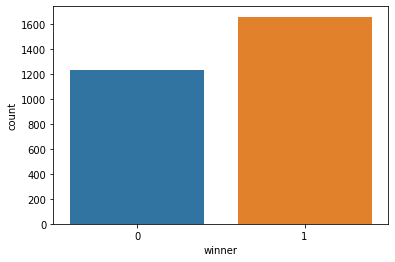

In [ ]:
sns.countplot(UFC_subset['winner'])

In [ ]:
UFC_subset.shape

(2884, 43)

In [ ]:
len(np.unique(UFC_subset['red_fighter'])), len(np.unique(UFC_subset['blue_fighter']))

(968, 1103)

In [ ]:
number_of_fights_per_fighter = UFC_subset['red_fighter'].append(UFC_subset['blue_fighter']).value_counts()

In [ ]:
number_of_fights_per_fighter

Alex Oliveira        19
Jim Miller           19
Donald Cerrone       18
Andrei Arlovski      18
Thiago Santos        17
                     ..
Dakota Bush           1
Keith Berish          1
Guram Kutateladze     1
Mike Jackson          1
Wang Guan             1
Length: 1255, dtype: int64

In [ ]:
number_of_fights_per_fighter[number_of_fights_per_fighter == 1]

Alex Gorgees           1
Uros Medic             1
Cody Durden            1
Andrew Craig           1
Andreas Michailidis    1
                      ..
Dakota Bush            1
Keith Berish           1
Guram Kutateladze      1
Mike Jackson           1
Wang Guan              1
Length: 225, dtype: int64

In [ ]:
number_of_fights_per_fighter[number_of_fights_per_fighter != 1]

Alex Oliveira        19
Jim Miller           19
Donald Cerrone       18
Andrei Arlovski      18
Thiago Santos        17
                     ..
Jacob Malkoun         2
Rafael Cavalcante     2
Sean Woodson          2
Jamall Emmers         2
Austin Lingo          2
Length: 1030, dtype: int64

# Creating averages for key stats

In [ ]:
Holland = get_fighter(UFC_subset,'Kevin Holland') # Chose him cause he has fought mad number of opponents. 
Holland = Holland.sort_values(by = 'date', ascending = True)

Holland_key_columns = Holland.copy()
Holland_key_columns = Holland_key_columns[['date','red_fighter','blue_fighter','winner',
                                          'red_sig_strike_percent', 'blue_sig_strike_percent',
                                          'red_takedown_percent', 'blue_takedown_percent',
                                          'red_submission_attempts', 'blue_submission_attempts', 
                                          'red_STANCE', 'blue_STANCE', 'red_total_strikes_percent',
                                          'blue_total_strikes_percent', 'red_takedowns_percent',
                                          'blue_takedowns_percent', 'Height_diff', 'Reach_diff', 
                                          'red_age','blue_age']]

In [ ]:
Holland_key_columns

,date,red_fighter,blue_fighter,winner,red_sig_strike_percent,blue_sig_strike_percent,red_takedown_percent,blue_takedown_percent,red_submission_attempts,blue_submission_attempts,red_STANCE,blue_STANCE,red_total_strikes_percent,blue_total_strikes_percent,red_takedowns_percent,blue_takedowns_percent,Height_diff,Reach_diff,red_age,blue_age
1297,2018-08-04,Thiago Santos,Kevin Holland,1,0.450980,0.563636,0.42,0.00,1,1,Orthodox,Orthodox,0.485030,0.736364,0.428571,0.000000,-2.54,-12.70,35,26
1181,2018-11-24,Kevin Holland,John Phillips,1,0.657754,0.331169,0.83,0.00,2,0,Southpaw,Southpaw,0.694915,0.339744,0.833333,0.000000,10.16,15.24,26,33
994,2019-03-30,Kevin Holland,Gerald Meerschaert,1,0.627907,0.769231,0.50,0.54,2,4,Southpaw,Southpaw,0.775510,0.785714,0.500000,0.545455,5.08,10.16,26,31
879,2019-06-22,Kevin Holland,Alessio Di Chirico,1,0.495726,0.607143,0.00,0.50,0,0,Orthodox,Orthodox,0.758893,0.639175,0.000000,0.500000,7.62,17.78,27,30
696,2019-10-18,Brendan Allen,Kevin Holland,1,0.454545,0.578947,0.66,1.00,4,1,Orthodox,Orthodox,0.560976,0.672727,0.666667,1.000000,-2.54,-15.24,24,27
484,2020-05-16,Anthony Hernandez,Kevin Holland,0,0.000000,0.777778,0.00,0.00,0,0,Orthodox,Orthodox,0.000000,0.777778,0.000000,0.000000,-7.62,-15.24,27,28
362,2020-08-08,Kevin Holland,Joaquin Buckley,1,0.589552,0.333333,0.00,0.00,0,0,Southpaw,Southpaw,0.609929,0.338843,0.000000,0.000000,12.70,12.70,28,26
300,2020-09-19,Kevin Holland,Darren Stewart,1,0.573643,0.518182,0.00,0.37,0,0,Orthodox,Orthodox,0.730942,0.610063,0.000000,0.375000,7.62,17.78,28,30
232,2020-10-31,Kevin Holland,Charlie Ontiveros,1,0.916667,1.000000,1.00,0.00,0,0,Switch,Switch,0.970588,1.000000,1.000000,0.000000,2.54,7.62,28,29
173,2020-12-12,Kevin Holland,Jacare Souza,1,0.833333,1.000000,0.00,0.66,0,0,Orthodox,Orthodox,0.875000,1.000000,0.000000,0.666667,5.08,22.86,28,41


In [ ]:
Holland_key_columns.index[0]

1297

In [ ]:
Holland_key_columns.loc[1297,'red_fighter']

'Thiago Santos'

In [ ]:
print('Date', "                    ",'Fighter',"     ", "Sig Strike Percent")
print('-----------------------------------')
for i in Holland_key_columns.index:
  if 'Kevin Holland' in Holland_key_columns.loc[i,'red_fighter']:
    print(Holland_key_columns.loc[i,'date'],"  ",Holland_key_columns.loc[i,'red_fighter'],"  ",Holland_key_columns.loc[i,'red_sig_strike_percent'])
  if 'Kevin Holland' in Holland_key_columns.loc[i,'blue_fighter']:
    print(Holland_key_columns.loc[i,'date'],"  ",Holland_key_columns.loc[i,'blue_fighter'],"  ",Holland_key_columns.loc[i,'blue_sig_strike_percent'])

Date                      Fighter       Sig Strike Percent
-----------------------------------
2018-08-04 00:00:00    Kevin Holland    0.5636363636363636
2018-11-24 00:00:00    Kevin Holland    0.6577540106951871
2019-03-30 00:00:00    Kevin Holland    0.627906976744186
2019-06-22 00:00:00    Kevin Holland    0.49572649572649574
2019-10-18 00:00:00    Kevin Holland    0.5789473684210527
2020-05-16 00:00:00    Kevin Holland    0.7777777777777778
2020-08-08 00:00:00    Kevin Holland    0.5895522388059702
2020-09-19 00:00:00    Kevin Holland    0.5736434108527132
2020-10-31 00:00:00    Kevin Holland    0.9166666666666666
2020-12-12 00:00:00    Kevin Holland    0.8333333333333334
2021-03-20 00:00:00    Kevin Holland    0.4864864864864865
2021-04-10 00:00:00    Kevin Holland    0.3592233009708738


In [ ]:
sig_strikes = []
for i in Holland_key_columns.index:
  if 'Kevin Holland' in Holland_key_columns.loc[i,'red_fighter']:
    sig_strikes.append(Holland_key_columns.loc[i,'red_sig_strike_percent'])
  if 'Kevin Holland' in Holland_key_columns.loc[i,'blue_fighter']:
    sig_strikes.append(Holland_key_columns.loc[i,'blue_sig_strike_percent'])

In [ ]:
df = pd.DataFrame(sig_strikes, columns=['Sig_strike_percent'])

In [ ]:
df = pd.DataFrame(sig_strikes, columns=['Sig_strike_percent'])
#df['sig_strike_minus_one'] = df['Sig_strike_percent'].shift(1)
#df = df.dropna()

In [ ]:
df 
# row 0 here is the stats from fight 1, so average going into fight 1 is NA, 
# then average going into fight 2 is the stats from fight 1, 
# then average going into fight 3 is mean of stats from fight 1 and fight 2. 


,Sig_strike_percent
0,0.563636
1,0.657754
2,0.627907
3,0.495726
4,0.578947
5,0.777778
6,0.589552
7,0.573643
8,0.916667
9,0.833333


In [ ]:
df.expanding(2).mean()

,Sig_strike_percent
0,NaN
1,0.610695
2,0.616432
3,0.586256
4,0.584794
5,0.616958
6,0.613043
7,0.608118
8,0.642401
9,0.661494


In [ ]:
df['Averages'] = df['Sig_strike_percent'].expanding(2).mean().shift(1)

In [ ]:
df.loc[1,'Averages'] = df.loc[0,'Sig_strike_percent']

In [ ]:
df 
# Now we can see that we are trying to fill that NA value using a linear regression. 
# Where y = Average going into fight t-1 and x = average going into fight t. 
# so for example for the third fight here (t = 3) we have y = the average going into fight 2 (0.56) and x = average going into fight 3 (0.61)

,Sig_strike_percent,Averages
0,0.563636,NaN
1,0.657754,0.563636
2,0.627907,0.610695
3,0.495726,0.616432
4,0.578947,0.586256
5,0.777778,0.584794
6,0.589552,0.616958
7,0.573643,0.613043
8,0.916667,0.608118
9,0.833333,0.642401


In [ ]:
lin_reg_df = df.copy()
lin_reg_df = lin_reg_df.rename(columns = {'Averages': 'X_average'})
lin_reg_df['Y_average'] = lin_reg_df['X_average'].shift(1)
lin_reg_df
# X_average is average going into fight t
# Y_average is average going into fight t-1 

,Sig_strike_percent,X_average,Y_average
0,0.563636,NaN,NaN
1,0.657754,0.563636,NaN
2,0.627907,0.610695,0.563636
3,0.495726,0.616432,0.610695
4,0.578947,0.586256,0.616432
5,0.777778,0.584794,0.586256
6,0.589552,0.616958,0.584794
7,0.573643,0.613043,0.616958
8,0.916667,0.608118,0.613043
9,0.833333,0.642401,0.608118


In [ ]:
lin_reg_df = lin_reg_df.dropna()
lin_reg_df 


,Sig_strike_percent,X_average,Y_average
2,0.627907,0.610695,0.563636
3,0.495726,0.616432,0.610695
4,0.578947,0.586256,0.616432
5,0.777778,0.584794,0.586256
6,0.589552,0.616958,0.584794
7,0.573643,0.613043,0.616958
8,0.916667,0.608118,0.613043
9,0.833333,0.642401,0.608118
10,0.486486,0.661494,0.642401
11,0.359223,0.645585,0.661494


In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
x, y = lin_reg_df['X_average'], lin_reg_df['Y_average']
x = x.values.reshape(-1,1)

In [ ]:
x, y

(array([[0.61069519],
        [0.61643245],
        [0.58625596],
        [0.58479424],
        [0.61695817],
        [0.61304303],
        [0.60811808],
        [0.64240126],
        [0.66149446],
        [0.64558465]]), 2     0.563636
 3     0.610695
 4     0.616432
 5     0.586256
 6     0.584794
 7     0.616958
 8     0.613043
 9     0.608118
 10    0.642401
 11    0.661494
 Name: Y_average, dtype: float64)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
prediction = np.array(0.563636).reshape(1,-1)

In [ ]:
lin_reg.predict(prediction)

array([0.57399667])

In [ ]:
fight_t = 

fight_t_minus_one = 

* fit a regression for each stat against the stat before the previous fight

* By that do you mean the dependent variable is statistic A's average going into fight t-1 and the independent variable is statistic A's average going into fight t, where for each row I'd have to match fights t-1 and t by fighter, but it'd still just be two variables overall? 

* Exactly! you could do it the other way round and have t against t-1 and then rearrange but either way is fine. 

* The assumptions mostly only affect the variance so I would check that there aren't any trends in the residuals and that the model is a reasonable fit to the data (plot the predictions against the observed values and add a line of equality slope 1 intercept 0 - the dream is having the points as close to the line of equality as possible) 


* Exclude fighters from these linear regressions who only have 1 fight 


In [ ]:
Holland_key_columns.info()

#Next steps 

Within the future events page we have a number of potentially useful variables: 

* avg fight time, height, weight, reach, stance, strikes landed per minutestrike accuracy, strikes absorbed p/m, defence (?)

*  average takedowns per 15 minutes, takedown accuracy (%), takedown defence, submission average per 15 mins. 

In the historical data we have the numbers for many of these for each fight. So the task is now to convert these to match the information we would get from looking at the future events data. 

** Challenges ** 

How do we construct these so they match the fighters stats * at the time of their current fight*. By this I mean, for say takedown accuracy, how do we figure out what their takedown accuracy was when they fought each particular fight? 